In [92]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [93]:
history_df = pd.read_json('data/streaming_history.json')
# print(history_df.head())

In [94]:
history_df.to_csv('data/streaming_history.csv', index=False)
print(history_df.shape)

(13509, 21)


In [95]:
history_df.info()
# We can probably drop episode name, episode show name and episode uri

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13509 entries, 0 to 13508
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 13509 non-null  object 
 1   username                           13509 non-null  object 
 2   platform                           13509 non-null  object 
 3   ms_played                          13509 non-null  int64  
 4   conn_country                       13509 non-null  object 
 5   ip_addr_decrypted                  13509 non-null  object 
 6   user_agent_decrypted               11607 non-null  object 
 7   master_metadata_track_name         13402 non-null  object 
 8   master_metadata_album_artist_name  13402 non-null  object 
 9   master_metadata_album_album_name   13402 non-null  object 
 10  spotify_track_uri                  13402 non-null  object 
 11  episode_name                       20 non-null     obj

In [96]:
spotify_stream_df = history_df[[
    'ts', 'ms_played', 'master_metadata_track_name', 'master_metadata_album_artist_name']].copy()
# spotify_stream_df.tail(3)
spotify_stream_df['ts'] = pd.to_datetime(spotify_stream_df['ts']) # convert to datetime

spotify_stream_df.sample(10)

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name
1875,2023-06-10 05:11:26+00:00,181909,Drums,Money Man
11582,2024-05-21 16:03:46+00:00,13684,3G (feat. Lil Uzi Vert),Yeat
1698,2023-06-06 19:35:06+00:00,19316,Close My Eyes,21 Savage
7653,2024-01-21 00:24:16+00:00,136615,On Me,Internet Money
13152,2024-06-11 17:35:04+00:00,293840,I Don't Like,Chief Keef
7568,2024-01-18 21:04:09+00:00,4360,A GHETTO CHRISTMAS CAROL,XXXTENTACION
9915,2024-03-31 18:29:56+00:00,110396,Voyage,Sleepermane
2089,2023-06-16 18:44:21+00:00,14600,"To Summer, From Cole - Audio Hug",Summer Walker
10507,2024-04-17 16:54:34+00:00,998,Dead or Alive,Lil Tecca
197,2021-06-12 17:32:02+00:00,209438,Dance Monkey,Tones And I


In [97]:
# Unique artists and tracks:
print("Unique Artists: ", len(spotify_stream_df["master_metadata_album_artist_name"].unique()))
print("Unique Tracks: ", len(spotify_stream_df["master_metadata_track_name"].unique()))


Unique Artists:  780
Unique Tracks:  2901


In [98]:
spotify_stream_df['play_time'] = pd.to_datetime(spotify_stream_df['ts'])
spotify_stream_df['year'] = pd.DatetimeIndex(spotify_stream_df['play_time']).year
spotify_stream_df['month'] = pd.DatetimeIndex(spotify_stream_df['play_time']).month
spotify_stream_df['day'] = pd.DatetimeIndex(spotify_stream_df['play_time']).day
spotify_stream_df['weekday'] = pd.DatetimeIndex(spotify_stream_df['play_time']).weekday
spotify_stream_df['hour'] = pd.DatetimeIndex(spotify_stream_df['play_time']).hour
spotify_stream_df['time'] = pd.DatetimeIndex(spotify_stream_df['play_time']).time
spotify_stream_df['day-name'] = spotify_stream_df['play_time'].apply(lambda x: x.day_name())
spotify_stream_df['count'] = 1

In [99]:
spotify_stream_df['time_played'] = pd.to_timedelta(spotify_stream_df['ms_played'], unit='ms')

def hours_played(time):
    return time.seconds / 3600
def minutes_played(time):
    return time.seconds / 60 % 60


spotify_stream_df["time_played_hours"] = spotify_stream_df["time_played"].apply(
    hours_played).round(3)
spotify_stream_df["time_played_minutes"] = spotify_stream_df["time_played"].apply(
    minutes_played).round(3)

In [100]:
spotify_stream_df.tail()

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,play_time,year,month,day,weekday,hour,time,day-name,count,time_played,time_played_hours,time_played_minutes
13504,2024-06-12 22:14:27+00:00,5189,That Fiya,Lil Uzi Vert,2024-06-12 22:14:27+00:00,2024,6,12,2,22,22:14:27,Wednesday,1,0 days 00:00:05.189000,0.001,0.083
13505,2024-06-12 22:14:30+00:00,3157,5!RE,Homixide Gang,2024-06-12 22:14:30+00:00,2024,6,12,2,22,22:14:30,Wednesday,1,0 days 00:00:03.157000,0.001,0.050
13506,2024-06-12 22:16:20+00:00,110926,Go,Ken Carson,2024-06-12 22:16:20+00:00,2024,6,12,2,22,22:16:20,Wednesday,1,0 days 00:01:50.926000,0.031,1.833
13507,2024-06-12 22:19:33+00:00,192213,"Like This (feat. Lil Uzi Vert, Destroy Lonely)",Ken Carson,2024-06-12 22:19:33+00:00,2024,6,12,2,22,22:19:33,Wednesday,1,0 days 00:03:12.213000,0.053,3.200
13508,2024-06-12 23:42:58+00:00,113030,Fighting My Demons,Ken Carson,2024-06-12 23:42:58+00:00,2024,6,12,2,23,23:42:58,Wednesday,1,0 days 00:01:53.030000,0.031,1.883


In [101]:
# no longer necessary
spotify_stream_df.drop(columns=['ts', 'time_played', 'ms_played'])
# All data cleaning is complete
spotify_stream_df.describe()

,ms_played,year,month,day,weekday,hour,count,time_played,time_played_hours,time_played_minutes
count,1.350900e+04,13509.000000,13509.000000,13509.000000,13509.000000,13509.000000,13509.0,13509,13509.000000,13509.000000
mean,9.868708e+04,2023.445111,6.052558,15.119846,2.994892,11.510252,1.0,0 days 00:01:38.687077429,0.027267,1.636687
std,9.559666e+04,0.619885,3.308833,8.660908,2.018581,8.555303,0.0,0 days 00:01:35.596663713,0.026561,1.593050
min,0.000000e+00,2020.000000,1.000000,1.000000,0.000000,0.000000,1.0,0 days 00:00:00,0.000000,0.000000
25%,5.320000e+03,2023.000000,4.000000,8.000000,1.000000,3.000000,1.0,0 days 00:00:05.320000,0.001000,0.083000
50%,8.953500e+04,2023.000000,6.000000,14.000000,3.000000,14.000000,1.0,0 days 00:01:29.535000,0.025000,1.483000
75%,1.708580e+05,2024.000000,9.000000,23.000000,5.000000,20.000000,1.0,0 days 00:02:50.858000,0.047000,2.833000
max,1.648635e+06,2024.000000,12.000000,31.000000,6.000000,23.000000,1.0,0 days 00:27:28.635000,0.458000,27.467000


In [102]:
sns.set_style('whitegrid')
# print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [103]:
# calculating average songs per artist
total_artists = spotify_stream_df['master_metadata_album_artist_name'].count()
unique_artists = spotify_stream_df['master_metadata_album_artist_name'].nunique()

average_songs_per_artist = total_artists / unique_artists
print(average_songs_per_artist)

17.20410783055199


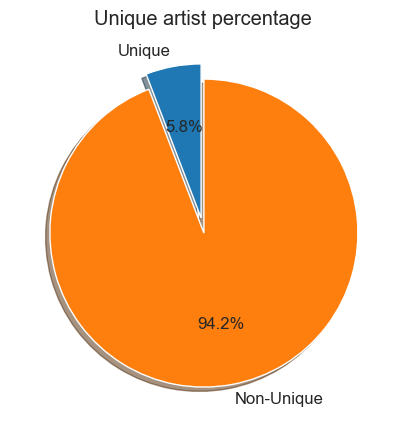

In [104]:
unique_artist_list = np.array([unique_artists, total_artists - unique_artists])
unique_artist_labels = ['Unique', 'Non-Unique']

fig, ax = plt.subplots()
ax.pie(unique_artist_list, labels=unique_artist_labels, autopct='%1.1f%%', startangle=90, shadow=True, explode = [0.05, 0.05])
plt.title("Unique artist percentage")
plt.show()

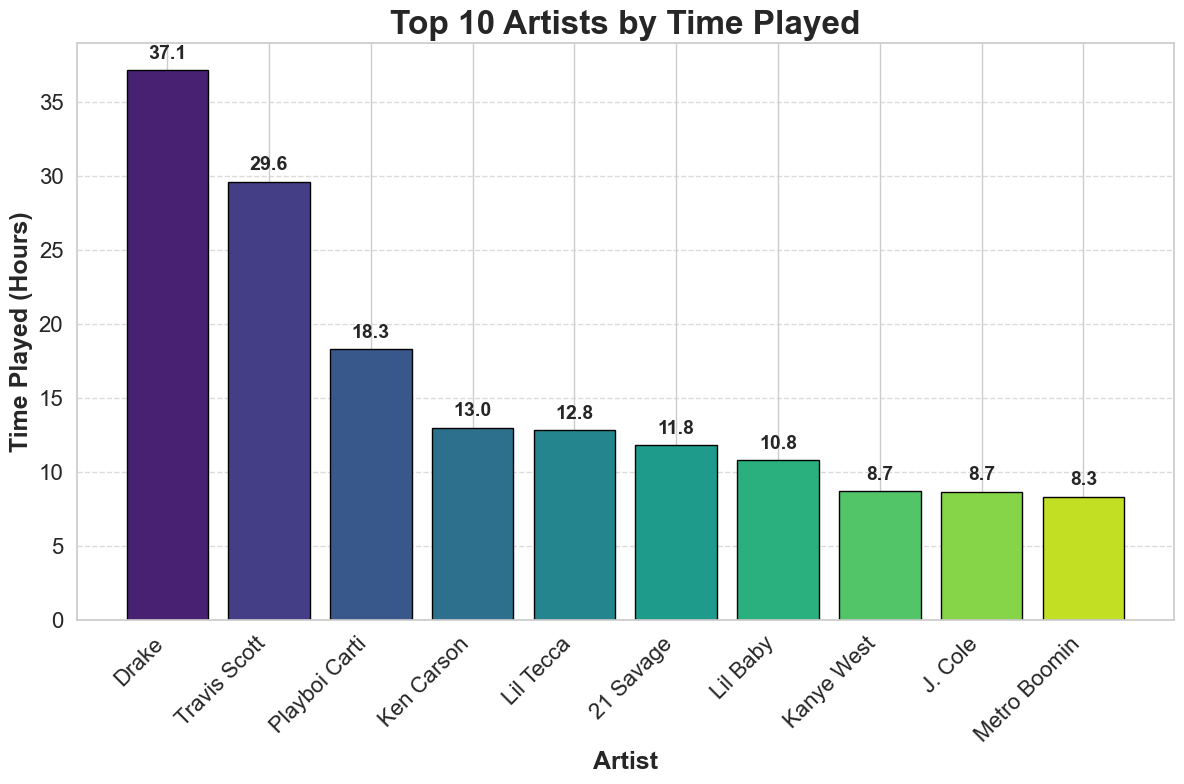

In [126]:
top_artists = spotify_stream_df.groupby(['master_metadata_album_artist_name'])[
    ['count', 'time_played_hours']].sum().sort_values(by='time_played_hours', ascending=False)
top_10_artists = top_artists.head(10)

# Set plot style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(top_10_artists))

plt.figure(figsize=(12, 8))
bars = plt.bar(top_10_artists.index,
               top_10_artists['time_played_hours'],
               color=palette,
               edgecolor='black')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1),
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Improve labels and title
plt.xlabel('Artist', fontsize=18, fontweight='bold')
plt.ylabel('Time Played (Hours)', fontsize=18, fontweight='bold')
plt.title('Top 10 Artists by Time Played', fontsize=24, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)

# Show gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()